#### There is an implementation of SIR model of epidemy spread simulation
There is implemeted SIR model that has 4 types of points in simulation: 0 - vaccinated, 1 - healed, 2 - vulnerable, 3 - sick. There are parameters such as probability of getting infected when being in neighbourhood of sick point and probability of getting healed. Also there is implemeted simulation of movement of points and simulation of antivaxxers that will never get vaccinated. Being healed and being vaccinated will not give points immunity forever. Days of being immune are also put as parameters. There is implemeted visualization i nform of animation that shows how epidemy is spreading and plots that show numbers of points in days.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib ipympl
import matplotlib.animation as animation

#### Parameters

In [11]:
popolation_size = 100**2
nr_of_days = 1500
number_of_patient_zero = 10
probability_of_getting_infected = 0.8
probability_of_getting_healed = 0.3
immune_days_after_being_sick = 30
immunce_days_after_vaccination = 200
how_many_people_get_vacinated = 30 #per day
how_many_people_move = 100 #per day; too much will result in chaotic representation; low values can visualize how healthy population can be infected by random contact with someone sick
day_vaccine_was_created = 50 # 0 if we want vaccine from first day
anti_vaxxer = 0 # from 0 to 1; percent of population who does not vaccinate; if >0 how_many_people_move should be set to 0

All functions that make simulation

In [12]:
# 0 - vaccinated
# 1 - healed
# 2 - vulnerable
# 3 - ill

def initialize_ill_people(population, max):
    size = population.shape[0]
    how_many = 0
    while how_many < max:
        x, y = np.random.randint(size), np.random.randint(size)
        if population[x,y] == 2:
            population[x,y] = 3
            how_many+=1

def vaccine_people(population, max, anti_vaxxer = False):
    size = population.shape[0]
    how_many = 0
    for _ in range(max) :
        x, y = np.random.randint(size), np.random.randint(size)
        if anti_vaxxer != 0:
            if x < anti_vaxxer or y < anti_vaxxer:
                if population[x,y] == 2:
                    population[x,y] = 0
                    how_many+=1
        else:
            if population[x,y] == 2:
                population[x,y] = 0
                how_many+=1

def heal(population, probability_of_getting_healed):
    idx = np.argwhere(population == 3)
    for i in range(len(idx)):
        if np.random.rand() < probability_of_getting_healed:
            population[idx[i][0], idx[i][1]] = 1

def get_neighbours(x,y):
    return [[x-1,y], [x+1,y], [x, y+1], [x, y-1]]

def infect(population, probability_of_getting_infected):
    idx = np.argwhere(population==3)
    for i in range(len(idx)):
        x,y = idx[i,0], idx[i,1]
        for neighbour_index in get_neighbours(x,y):
            try:
                if population[neighbour_index[0], neighbour_index[1]] == 2 and np.random.rand() < probability_of_getting_infected:
                    population[neighbour_index[0], neighbour_index[1]] = 3
            except:
                pass    

def simulate_movement(population, nr_of_moving_people):
    for _ in range(nr_of_moving_people):
        size = population.shape[0]
        x1, y1 = np.random.randint(size), np.random.randint(size)
        x2, y2 = np.random.randint(size), np.random.randint(size)
        population[x1,y1], population[x2,y2] = population[x2,y2], population[x1,y1]

def loose_immunity(population, probability_of_losing_immunuty):
    idx = np.argwhere(population == 1)
    for i in range(len(idx)):
        if np.random.rand() < probability_of_losing_immunuty:
            population[idx[i][0], idx[i][1]] = 2

def loose_vaccine_immunity(population, probability_of_losing_vaccine_immunuty):
    idx = np.argwhere(population == 0)
    for i in range(len(idx)):
        if np.random.rand() < probability_of_losing_vaccine_immunuty:
            population[idx[i][0], idx[i][1]] = 2

def show_population(population):
    plt.figure(figsize=(20,10))
    mynorm = plt.Normalize(vmin=0, vmax=3)
    plt.imshow(population, norm=mynorm)
    plt.colorbar()
    #plt.show()


def get_data(population, dataframe, day_number):
    vaccine = len(np.argwhere(population == 0 ))
    healed = len(np.argwhere(population == 1 ))
    vulnerable = len(np.argwhere(population == 2 ))
    ill = len(np.argwhere(population == 3 ))
    dataframe = pd.concat([dataframe, pd.DataFrame({'day': [day_number], 'vaccine': [vaccine], 'healed': [healed], 'vulnerable':[vulnerable], 'sick': [ill]})])
    return dataframe

def simulate_one_day(population, prob_heal, prob_infect, immune_days, vaccine_immune_days,how_many_people_move, how_many_people_get_vaccine_per_day,plots, show = False, vaccine = False, anti_vaxxer = False):
    simulate_movement(population=population, nr_of_moving_people=how_many_people_move)
    infect(population=population, probability_of_getting_infected=prob_infect)
    heal(population=population, probability_of_getting_healed=prob_heal)
    loose_immunity(population=population, probability_of_losing_immunuty=1/immune_days)
    if vaccine:
        vaccine_people(population=population, max=how_many_people_get_vaccine_per_day, anti_vaxxer = anti_vaxxer)    
        loose_vaccine_immunity(population=population, probability_of_losing_vaccine_immunuty=1/vaccine_immune_days)
    mynorm = plt.Normalize(vmin=0, vmax=3)
    plot = ax.imshow(population, norm=mynorm, animated = True)
    plots.append([plot])
    



#### Animation

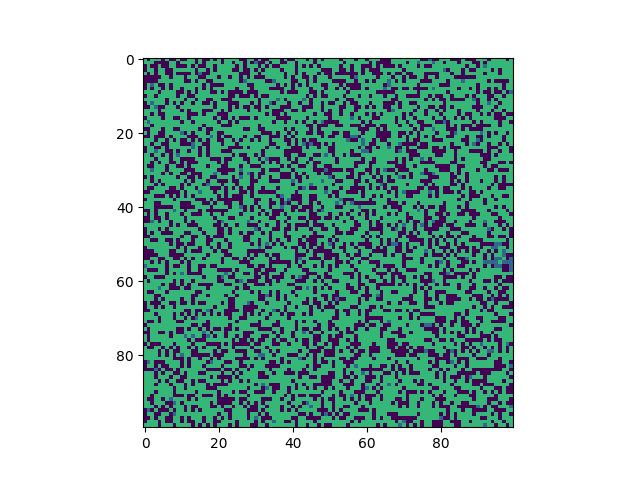

In [13]:
N = popolation_size
plots =[]
fig, ax = plt.subplots()
df = pd.DataFrame(columns=['day','vaccine', 'healed', 'vulnerable', 'sick'])
side_len = int(np.sqrt(N))
population = np.zeros((side_len,side_len)) +2 #initialize vulnerable population
initialize_ill_people(population=population,max=number_of_patient_zero)
vaccine = False
for day in range(nr_of_days):
    if day == day_vaccine_was_created:
        vaccine = True
    simulate_one_day(population=population, 
                     prob_heal=probability_of_getting_healed, 
                     prob_infect=probability_of_getting_infected, 
                     immune_days=immune_days_after_being_sick, 
                     vaccine_immune_days=immunce_days_after_vaccination, 
                     how_many_people_move=how_many_people_move, 
                     how_many_people_get_vaccine_per_day=how_many_people_get_vacinated,
                     plots = plots, 
                     vaccine=vaccine, 
                     anti_vaxxer = N*(1 - anti_vaxxer)/np.sqrt(N))
    df = get_data(population=population, dataframe=df, day_number=day)
    if len(np.argwhere(population==3)) == 0:
        break
df.set_index('day', inplace=True)
ani = animation.ArtistAnimation(fig, plots, interval=200, blit=True, repeat = False)
plt.show()


#### Plots

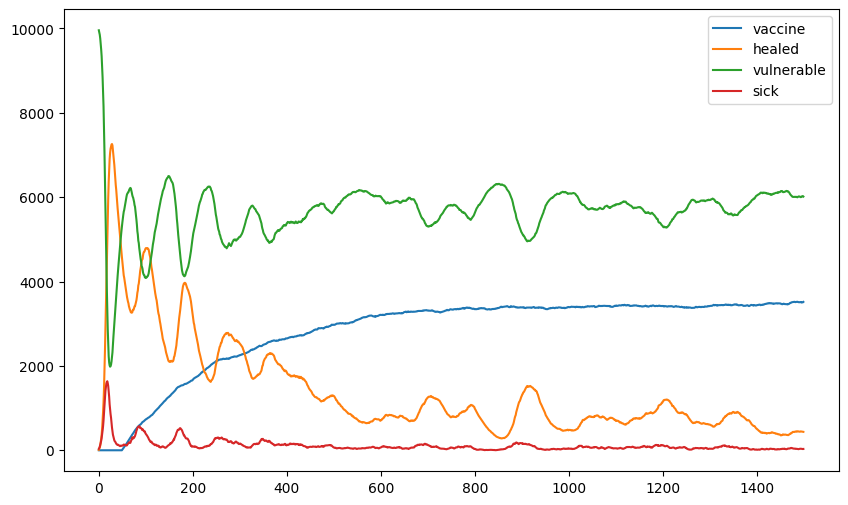

In [7]:
plt.figure(figsize=(10,6))

plt.plot(df['vaccine'])
plt.plot(df['healed'])
plt.plot(df['vulnerable'])
plt.plot(df['sick'])
plt.legend(['vaccine', 'healed', 'vulnerable', 'sick'])
plt.show()

#### Other parameters

40% of population are antivaxxers

In [8]:
popolation_size = 100**2
nr_of_days = 1000
number_of_patient_zero = 10
probability_of_getting_infected = 0.8
probability_of_getting_healed = 0.1
immune_days_after_being_sick = 30
immunce_days_after_vaccination = 200
how_many_people_get_vacinated = 70 #per day
how_many_people_move = 0 #per day; too much will result in chaotic representation; low values can visualize how healthy population can be infected by random contact with someone sick
day_vaccine_was_created = 50 # 0 if we want vaccine from first day
anti_vaxxer = 0.4 # from 0 to 1; percent of population who does not vaccinate; if >0 how_many_people_move should be set to 0

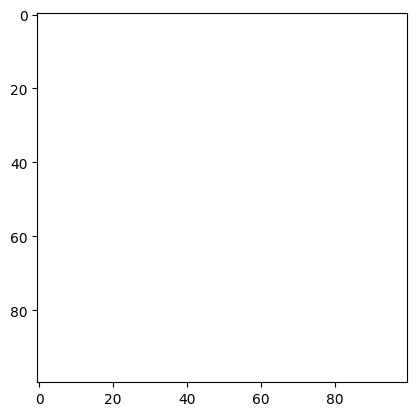

In [9]:
N = popolation_size
plots =[]
fig, ax = plt.subplots()
df = pd.DataFrame(columns=['day','vaccine', 'healed', 'vulnerable', 'sick'])
side_len = int(np.sqrt(N))
population = np.zeros((side_len,side_len)) +2 #initialize vulnerable population
initialize_ill_people(population=population,max=number_of_patient_zero)
vaccine = False
for day in range(nr_of_days):
    if day == day_vaccine_was_created:
        vaccine = True
    simulate_one_day(population=population, 
                     prob_heal=probability_of_getting_healed, 
                     prob_infect=probability_of_getting_infected, 
                     immune_days=immune_days_after_being_sick, 
                     vaccine_immune_days=immunce_days_after_vaccination, 
                     how_many_people_move=how_many_people_move, 
                     how_many_people_get_vaccine_per_day=how_many_people_get_vacinated,
                     plots = plots, 
                     vaccine=vaccine, 
                     anti_vaxxer = N*(1 - anti_vaxxer)/np.sqrt(N))
    df = get_data(population=population, dataframe=df, day_number=day)
    if len(np.argwhere(population==3)) == 0:
        break
df.set_index('day', inplace=True)
ani = animation.ArtistAnimation(fig, plots, interval=200, blit=True, repeat = False)
plt.show()


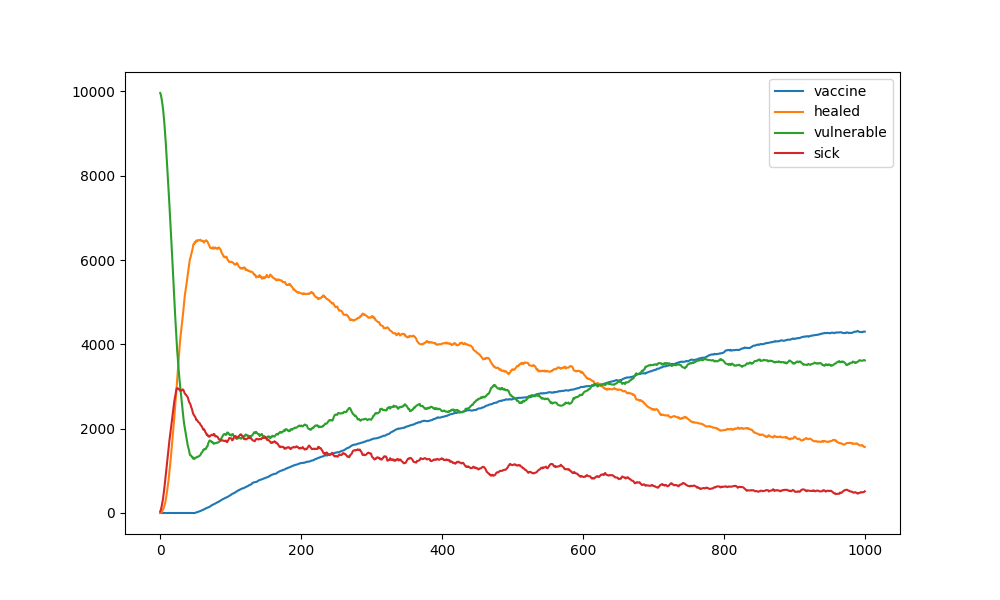

In [8]:
plt.figure(figsize=(10,6))

plt.plot(df['vaccine'])
plt.plot(df['healed'])
plt.plot(df['vulnerable'])
plt.plot(df['sick'])
plt.legend(['vaccine', 'healed', 'vulnerable', 'sick'])
plt.show()

### Few simulations all at once

In [9]:
popolation_size = 100**2
nr_of_days = 1500
number_of_patient_zero = 10
probability_of_getting_infected = 0.8
probability_of_getting_healed = 0.1
immune_days_after_being_sick = 30
immunce_days_after_vaccination = 200
how_many_people_get_vacinated = 70 #per day
how_many_people_move = 30 #per day; too much will result in chaotic representation; low values can visualize how healthy population can be infected by random contact with someone sick
day_vaccine_was_created = 50 # 0 if we want vaccine from first day
anti_vaxxer = 0 # from 0 to 1; percent of population who does not vaccinate; if >0 how_many_people_move should be set to 0

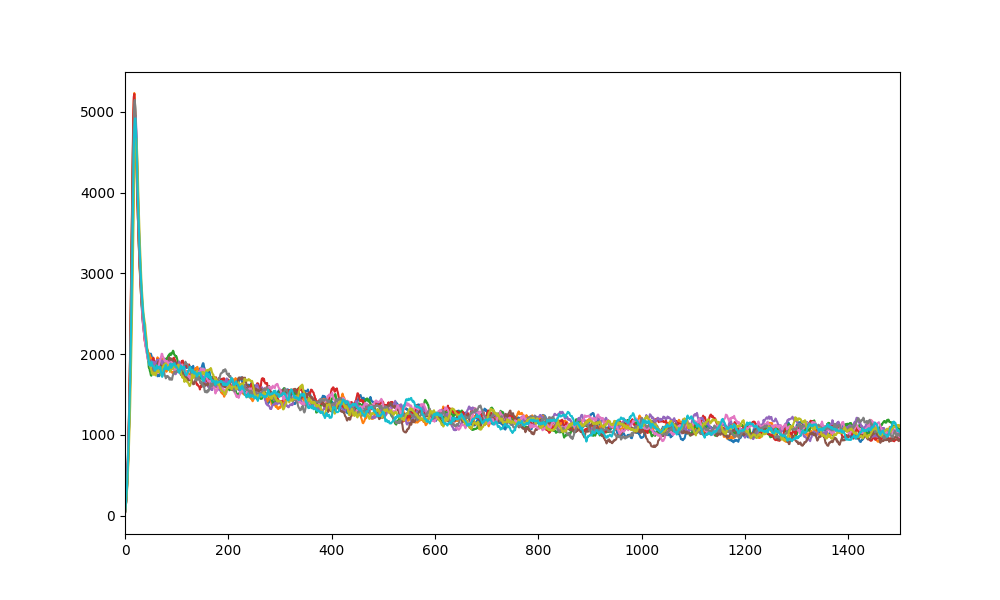

In [10]:
plt.figure(figsize=(10,6))
plt.xlim(0,nr_of_days)
for _ in range(10):
    N = popolation_size
    plots =[]
    df = pd.DataFrame(columns=['day','vaccine', 'healed', 'vulnerable', 'sick'])
    side_len = int(np.sqrt(N))
    population = np.zeros((side_len,side_len)) +2 #initialize vulnerable population
    initialize_ill_people(population=population,max=number_of_patient_zero)
    vaccine = False
    for day in range(nr_of_days):
        if day == day_vaccine_was_created:
            vaccine = True
        simulate_one_day(population=population, 
                        prob_heal=probability_of_getting_healed, 
                        prob_infect=probability_of_getting_infected, 
                        immune_days=immune_days_after_being_sick, 
                        vaccine_immune_days=immunce_days_after_vaccination, 
                        how_many_people_move=how_many_people_move, 
                        how_many_people_get_vaccine_per_day=how_many_people_get_vacinated,
                        plots = plots, 
                        vaccine=vaccine, 
                        anti_vaxxer = N*(1 - anti_vaxxer)/np.sqrt(N))
        df = get_data(population=population, dataframe=df, day_number=day)
        if len(np.argwhere(population==3)) == 0:
            break
    df.set_index('day', inplace=True)
    plt.plot(df['sick'])



In [12]:
popolation_size = 100**2
nr_of_days = 1500
number_of_patient_zero = 10
probability_of_getting_infected = 0.8
probability_of_getting_healed = 0.3
immune_days_after_being_sick = 50
immunce_days_after_vaccination = 200
how_many_people_get_vacinated = 30 #per day
how_many_people_move = 200 #per day; too much will result in chaotic representation; low values can visualize how healthy population can be infected by random contact with someone sick
day_vaccine_was_created = 50 # 0 if we want vaccine from first day
anti_vaxxer = 0 # from 0 to 1; percent of population who does not vaccinate; if >0 how_many_people_move should be set to 0

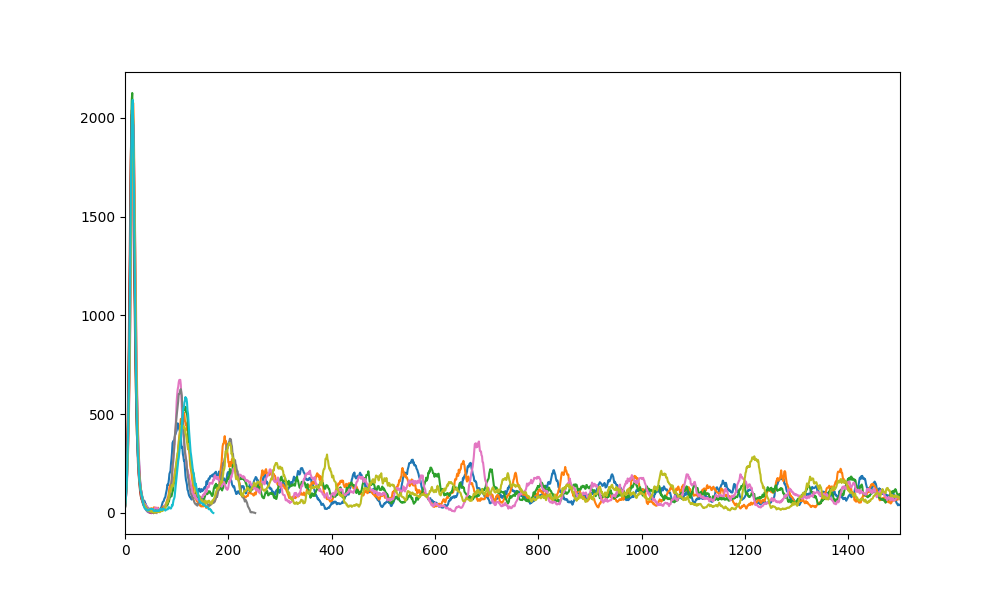

In [13]:
plt.figure(figsize=(10,6))
plt.xlim(0,nr_of_days)
for _ in range(10):
    N = popolation_size
    plots =[]
    df = pd.DataFrame(columns=['day','vaccine', 'healed', 'vulnerable', 'sick'])
    side_len = int(np.sqrt(N))
    population = np.zeros((side_len,side_len)) +2 #initialize vulnerable population
    initialize_ill_people(population=population,max=number_of_patient_zero)
    vaccine = False
    for day in range(nr_of_days):
        if day == day_vaccine_was_created:
            vaccine = True
        simulate_one_day(population=population, 
                        prob_heal=probability_of_getting_healed, 
                        prob_infect=probability_of_getting_infected, 
                        immune_days=immune_days_after_being_sick, 
                        vaccine_immune_days=immunce_days_after_vaccination, 
                        how_many_people_move=how_many_people_move, 
                        how_many_people_get_vaccine_per_day=how_many_people_get_vacinated,
                        plots = plots, 
                        vaccine=vaccine, 
                        anti_vaxxer = N*(1 - anti_vaxxer)/np.sqrt(N))
        df = get_data(population=population, dataframe=df, day_number=day)
        if len(np.argwhere(population==3)) == 0:
            break
    df.set_index('day', inplace=True)
    plt.plot(df['sick'])

#### Checking how the probability of getting infected influecne way that it spreads

In [22]:
popolation_size = 100**2
nr_of_days = 1500
number_of_patient_zero = 10
probability_of_getting_infected = 0.2
probability_of_getting_healed = 0.3
immune_days_after_being_sick = 50
immunce_days_after_vaccination = 200
how_many_people_get_vacinated = 30 #per day
how_many_people_move = 200 #per day; too much will result in chaotic representation; low values can visualize how healthy population can be infected by random contact with someone sick
day_vaccine_was_created = 50 # 0 if we want vaccine from first day
anti_vaxxer = 0 # from 0 to 1; percent of population who does not vaccinate; if >0 how_many_people_move should be set to 0

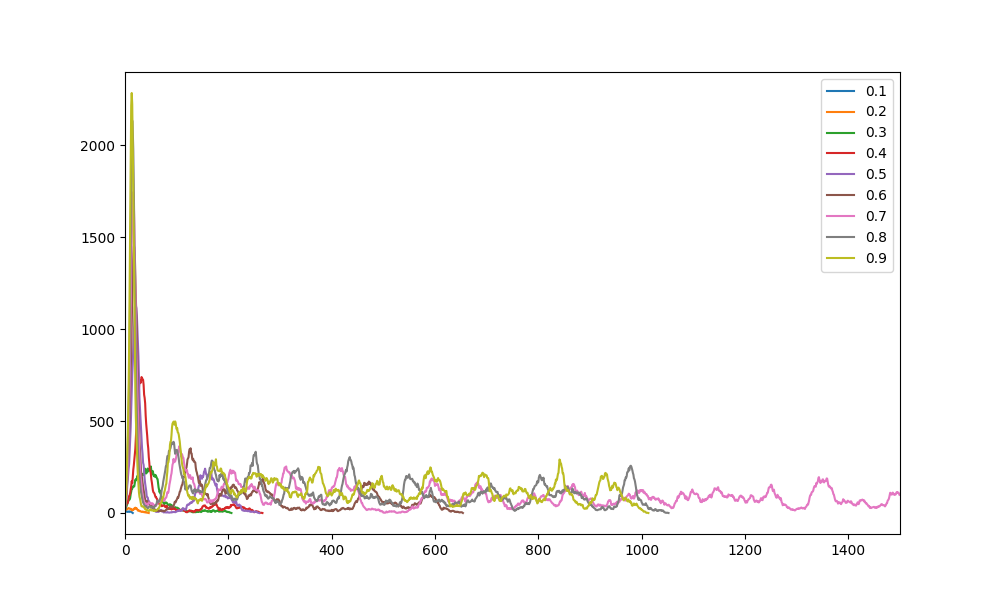

In [25]:
plt.figure(figsize=(10,6))
plt.xlim(0,nr_of_days)
for probability_of_getting_infected in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    N = popolation_size
    plots =[]
    df = pd.DataFrame(columns=['day','vaccine', 'healed', 'vulnerable', 'sick'])
    side_len = int(np.sqrt(N))
    population = np.zeros((side_len,side_len)) +2 #initialize vulnerable population
    initialize_ill_people(population=population,max=number_of_patient_zero)
    vaccine = False
    for day in range(nr_of_days):
        if day == day_vaccine_was_created:
            vaccine = True
        simulate_one_day(population=population, 
                        prob_heal=probability_of_getting_healed, 
                        prob_infect=probability_of_getting_infected, 
                        immune_days=immune_days_after_being_sick, 
                        vaccine_immune_days=immunce_days_after_vaccination, 
                        how_many_people_move=how_many_people_move, 
                        how_many_people_get_vaccine_per_day=how_many_people_get_vacinated,
                        plots = plots, 
                        vaccine=vaccine, 
                        anti_vaxxer = N*(1 - anti_vaxxer)/np.sqrt(N))
        df = get_data(population=population, dataframe=df, day_number=day)
        if len(np.argwhere(population==3)) == 0:
            break
    df.set_index('day', inplace=True)
    plt.plot(df['sick'], label = probability_of_getting_infected)
plt.legend()

#### Checking how the probability of getting healed influence way that it spreads

In [27]:
popolation_size = 100**2
nr_of_days = 1500
number_of_patient_zero = 10
probability_of_getting_infected = 0.8
probability_of_getting_healed = 0.3
immune_days_after_being_sick = 50
immunce_days_after_vaccination = 200
how_many_people_get_vacinated = 30 #per day
how_many_people_move = 200 #per day; too much will result in chaotic representation; low values can visualize how healthy population can be infected by random contact with someone sick
day_vaccine_was_created = 50 # 0 if we want vaccine from first day
anti_vaxxer = 0 # from 0 to 1; percent of population who does not vaccinate; if >0 how_many_people_move should be set to 0

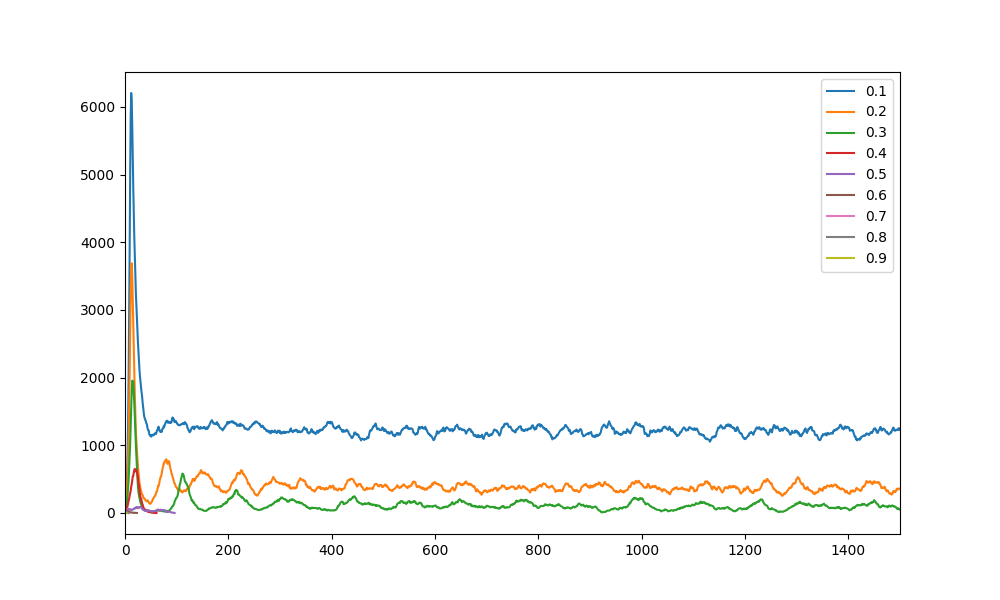

In [28]:
plt.figure(figsize=(10,6))
plt.xlim(0,nr_of_days)
for probability_of_getting_healed in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    N = popolation_size
    plots =[]
    df = pd.DataFrame(columns=['day','vaccine', 'healed', 'vulnerable', 'sick'])
    side_len = int(np.sqrt(N))
    population = np.zeros((side_len,side_len)) +2 #initialize vulnerable population
    initialize_ill_people(population=population,max=number_of_patient_zero)
    vaccine = False
    for day in range(nr_of_days):
        if day == day_vaccine_was_created:
            vaccine = True
        simulate_one_day(population=population, 
                        prob_heal=probability_of_getting_healed, 
                        prob_infect=probability_of_getting_infected, 
                        immune_days=immune_days_after_being_sick, 
                        vaccine_immune_days=immunce_days_after_vaccination, 
                        how_many_people_move=how_many_people_move, 
                        how_many_people_get_vaccine_per_day=how_many_people_get_vacinated,
                        plots = plots, 
                        vaccine=vaccine, 
                        anti_vaxxer = N*(1 - anti_vaxxer)/np.sqrt(N))
        df = get_data(population=population, dataframe=df, day_number=day)
        if len(np.argwhere(population==3)) == 0:
            break
    df.set_index('day', inplace=True)
    plt.plot(df['sick'], label = probability_of_getting_healed)
plt.legend()